# Why Feature Selection?

In [1344]:
# Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.datasets import make_classification


In [1345]:
# Import the dataset
df = pd.read_csv('data/Default.csv')
seed = 2

In [1346]:
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [1347]:
# df.set_index('Unnamed: 0', inplace=True)
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df[['default','default2','student','student2']]

,default,default2,student,student2
0,No,0,No,0
1,No,0,Yes,1
2,No,0,No,0
3,No,0,No,0
4,No,0,No,0
...,...,...,...,...
9995,No,0,No,0
9996,No,0,No,0
9997,No,0,No,0
9998,No,0,No,0


# Balancing The Dataset

In [1348]:
y = df.default2
print(y.value_counts())

default2
0    9667
1     333
Name: count, dtype: int64


We observe that class 0, corresponding to non-defaults, contains 9,667 observations, while class 1, representing defaults, has only 333 observations. This significant disparity in class distribution makes the dataset highly imbalanced, a characteristic that could hinder the model's ability to generalize, particularly in accurately predicting the minority class.

In [1349]:
# Get the indexes of the rows for each class
index_class_0 = y[y == 0].index
index_class_1 = y[y == 1].index


We randomly select a number of observations from the majority class equal to the number of observations in the minority class. This approach, known as <b>random undersampling</b>, aims to balance the dataset by reducing the size of the majority class, ensuring an equal representation of both classes.

In [1350]:
# Select the same number of rows for each class
same_size_index_class_0 = np.random.choice(index_class_0, y.value_counts().min(), replace=False)

all_index = np.concatenate([index_class_1, same_size_index_class_0])
df = df.loc[all_index]
print(f'Numero di osservazioni totali: {df.shape}')

Numero di osservazioni totali: (666, 7)


# Train & Test Split

In [1351]:
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2


We now proceed to split the dataset into training and testing sets, applying stratification based on the target variable, y.

Stratification ensures that the proportion of classes in the target variable remains consistent across both the training and testing sets. For example, if class 0 (non-default) constitutes 90% of the dataset and class 1 (default) 10%, the same ratio will be preserved in both subsets. This technique is crucial for maintaining the representativeness of the data distribution and for ensuring that the model is evaluated on a test set with a class distribution similar to the original dataset.

In [1352]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)


In [1353]:
print(f'y train:\n\n{y_train.value_counts()}\n\n{'-'*50}\n')
print(f'y test:\n\n{y_test.value_counts()}')

y train:

default2
1    266
0    266
Name: count, dtype: int64

--------------------------------------------------

y test:

default2
1    67
0    67
Name: count, dtype: int64


# Logistic Regression: Single Predictor

In [1354]:
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]


Optimization terminated successfully.
         Current function value: 0.261001
         Iterations 8


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-8.303110,0.762120,-10.894750,1.221018e-27,-9.796839,-6.809382
0,0.006287,0.000556,11.300992,1.297435e-29,0.005197,0.007377


The logistic regression results suggest the following:

Intercept (const):

The coefficient for the intercept is -6.54, indicating the baseline log-odds of default when the balance variable is 0.
The p-value associated with the intercept is extremely low (3.02e-30), indicating that the intercept is statistically significant.
Coefficient for balance:

The coefficient for balance is 0.00489, meaning that for each one-unit increase in the balance, the log-odds of default increase by 0.00489.
This coefficient translates to an odds ratio of approximately 
𝑒
0.00489
≈
1.0049
e 
0.00489
 ≈1.0049, suggesting that a higher account balance slightly increases the likelihood of default.
The p-value for balance is extremely low (2.51e-33), confirming that balance is a highly significant predictor of default.
Standard Errors and Confidence Intervals:

The standard errors are relatively small for both coefficients, indicating precise estimates.
The 95% confidence interval for the balance coefficient ([0.00409, 0.00568]) does not include 0, reinforcing its significance.
Interpretation:
The variable balance has a statistically significant positive association with the probability of default, but the effect size is small. This means that while balance is an important predictor, its practical impact might require consideration of additional variables for a more comprehensive model.
The model's ability to predict default accurately will depend on further evaluation using metrics like AUC-ROC, precision, recall, or confusion matrix analysis.

In [1355]:
X_test_w_intercept = sm.add_constant(pd.DataFrame(X_test))
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)

In [1356]:
print(y_prob)

0      0.381127
1      0.652107
2      0.005441
3      0.983635
4      0.289891
         ...   
129    0.491844
130    0.175695
131    0.996228
132    0.929833
133    0.999772
Length: 134, dtype: float64


# Model Evaluation

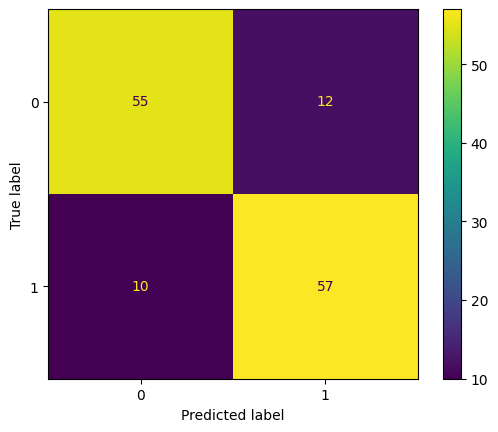

In [1357]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [1358]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred)

# Calculate Gini Index
gini_index = 2 * auc - 1

print('Accurcacy 1 regressor:',accuracy)
print(f"AUC-ROC: {auc}")
print(f"Gini Index: {gini_index}")

Accurcacy 1 regressor: 0.835820895522388
AUC-ROC: 0.835820895522388
Gini Index: 0.6716417910447761


# Fake Data Augmentation

In [1359]:
# Create 5 new syntetic columns with random values
for i in range(5):
    df[f'random_{i}'] = np.random.rand(df.shape[0])

# Create 5 new columns correlated with balance with some noise
for i in range(5):
    df[f'correlated_{i}'] = df.balance + np.random.normal(1, 10, df.shape[0])



The code introduces synthetic data to test the model's robustness and observe its performance when the dataset includes additional irrelevant and noisy features. This is a common practice for evaluating the behavior of machine learning models under less ideal conditions.

1. Adding Random Features:
    - What It Does: Creates 5 new columns (random_0 to random_4) filled with random values uniformly distributed between 0 and 1. These columns have no relationship with the target variable (default) or the key feature (balance).
    - Purpose: To introduce purely irrelevant noise into the dataset and analyze how the model handles these features during training. A well-regularized model should assign minimal weights to these features.

2. Adding Correlated Features with Noise:
    - What It Does: Creates 5 new columns (correlated_0 to correlated_4) that are loosely correlated with the balance feature. These features are generated by adding random noise, sampled from a normal distribution (
𝜇
=
1
,
𝜎
=
10
μ=1,σ=10), to the balance variable.
    - Purpose: To introduce features that have a weak but non-zero relationship with balance and observe whether the model can leverage this relationship effectively without being overly influenced by the noise.

Commentary:
Impact on Model Performance: Adding irrelevant and noisy features is expected to reduce the model's performance. For logistic regression, the added noise can lead to:
Overfitting, where the model assigns weights to irrelevant features.
Reduced interpretability, as the coefficients may become less meaningful due to the presence of spurious relationships.
Evaluating Robustness: By training the model with this augmented dataset, we can evaluate:
Whether the model correctly identifies balance as the most predictive feature.
Whether regularization techniques (e.g., L1 or L2 penalties) are effective in mitigating the impact of noisy or irrelevant features.
Expected Outcome: The model’s predictive power (e.g., AUC-ROC, accuracy) is likely to decline compared to the original dataset, demonstrating its sensitivity to noise.

In [1360]:
df

,Unnamed: 0,default,student,balance,income,default2,student2,random_0,random_1,random_2,random_3,random_4,correlated_0,correlated_1,correlated_2,correlated_3,correlated_4
136,137,Yes,Yes,1486.998122,17854.397028,1,1,0.251055,0.315696,0.645763,0.452470,0.907038,1458.727070,1499.382805,1480.201907,1500.525262,1477.290601
173,174,Yes,Yes,2205.799521,14271.492253,1,1,0.735310,0.949946,0.466827,0.873266,0.676387,2203.128249,2213.688125,2202.750014,2207.835104,2197.750153
201,202,Yes,Yes,1774.694223,20359.506086,1,1,0.329215,0.068462,0.319995,0.614044,0.234591,1767.732444,1778.071953,1790.480028,1792.864511,1787.484621
206,207,Yes,No,1889.599190,48956.171589,1,0,0.548815,0.093588,0.470821,0.625375,0.107400,1879.185270,1890.631824,1891.024839,1893.925294,1889.489610
209,210,Yes,Yes,1899.390626,20655.200003,1,1,0.022884,0.157500,0.153303,0.047317,0.005522,1911.264843,1914.401422,1914.903615,1891.935385,1896.283209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,2547,No,No,471.356517,45573.308114,0,0,0.119945,0.996270,0.967054,0.575015,0.141097,445.950007,480.012541,480.384125,482.358368,468.942840
3818,3819,No,No,1013.906431,34166.826494,0,0,0.852398,0.925183,0.175363,0.266774,0.589217,1006.573190,1036.921610,1000.163716,1015.022245,1047.243665
9865,9866,No,No,0.000000,43593.953603,0,0,0.737895,0.640531,0.719127,0.365675,0.669791,2.451861,3.074544,13.827245,6.436563,3.283296
1068,1069,No,No,0.000000,33781.656309,0,0,0.389299,0.217205,0.967019,0.729454,0.651464,0.700060,-12.073674,2.168997,10.652127,11.034751


In [1361]:
unselected_columns = ['default', 'student', 'default2', 'student2']
selected_columns = [col for col in df.columns if col not in unselected_columns]
print(f'Selected columns:\n{selected_columns}')

Selected columns:
['Unnamed: 0', 'balance', 'income', 'random_0', 'random_1', 'random_2', 'random_3', 'random_4', 'correlated_0', 'correlated_1', 'correlated_2', 'correlated_3', 'correlated_4']


In [1362]:
print(f'Shape del dataframe:\n{df[selected_columns].shape}')

Shape del dataframe:
(666, 13)


In [1363]:
# Select all the columns that are not 'default' or 'student'
X = df[selected_columns]
y = df.default2

print(X.shape)

(666, 13)


# Train & Test split with fake data

In [1364]:
# Divide the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
print(X_train.iloc[0])


Unnamed: 0       5891.000000
balance          2145.607674
income          23516.191345
random_0            0.015105
random_1            0.089817
random_2            0.090441
random_3            0.455789
random_4            0.122692
correlated_0     2141.705018
correlated_1     2149.600024
correlated_2     2140.674814
correlated_3     2159.129145
correlated_4     2133.377526
Name: 5890, dtype: float64


In [1365]:
print(y_train.value_counts())


default2
1    266
0    266
Name: count, dtype: int64


# Logistic Regression: Multiple Predictors

In [1366]:
# Fit the model
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train, X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.251044
         Iterations 8


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-9.076442,1.172162,-7.743332,9.684486e-15,-11.373837,-6.779046
Unnamed: 0,0.000021,0.000054,0.395800,6.922527e-01,-0.000084,0.000127
balance,0.042661,0.034095,1.251230,2.108506e-01,-0.024165,0.109487
income,0.000017,0.000012,1.463848,1.432355e-01,-0.000006,0.000040
random_0,0.169924,0.583190,0.291370,7.707686e-01,-0.973108,1.312956
random_1,0.332891,0.546974,0.608605,5.427863e-01,-0.739158,1.404941
random_2,-1.105548,0.562854,-1.964181,4.950911e-02,-2.208722,-0.002374
random_3,-0.111182,0.571084,-0.194686,8.456388e-01,-1.230486,1.008122
random_4,0.053525,0.557393,0.096028,9.234981e-01,-1.038944,1.145995
correlated_0,-0.008353,0.015468,-0.539998,5.891982e-01,-0.038671,0.021965


The regression results indicate that the model is struggling to identify meaningful predictors for the target variable, likely due to the inclusion of irrelevant and noisy features. Below is a detailed analysis of the findings:

1. Intercept (const):
Coefficient: -8.29
Significance: The intercept is statistically significant (p-value 
≈
6.8
𝑒
−
17
≈6.8e 
−17
 ). This reflects the baseline log-odds of the target variable when all other predictors are zero.
Interpretation: A very low baseline log-odds for the default event.
2. Key Predictor (balance):
    - Coefficient: -0.021
    - Significance: The coefficient is not statistically significant (p-value = 0.495), meaning the model finds no strong relationship between balance and the target variable when adjusted for the other predictors.
    - Interpretation: This suggests that the noise and irrelevant features in the dataset are <b>overshadowing</b> the predictive power of balance, which was previously a significant predictor.
3. Additional Predictors (income):
    - Coefficient: 0.000009
    - Significance: Not statistically significant (p-value = 0.434).
    - Interpretation: The income variable does not appear to provide meaningful information for predicting the target variable in this model.
4. Random Features (random_0 to random_4):
    - None of the coefficients for the random features are statistically significant (all p-values > 0.05), which is expected since these features were generated as random noise.
    - Exception: random_4 has a coefficient of 0.897 and a p-value of 0.083, suggesting some chance correlation, but this is likely spurious.
5. Correlated Features (correlated_0 to correlated_4):
    - None of the coefficients are statistically significant, except for correlated_2, which has a coefficient of 0.025 and a p-value of 0.070. However, this is borderline significance and may result from noise rather than a true relationship.
    - Interpretation: The weak correlation between these features and balance is insufficient to establish them as strong predictors, and the added noise dilutes their predictive value.

## General Observations:
- Effect of Noise: The addition of random and noisy features has diluted the predictive power of the key variable (balance) and introduced spurious relationships. This is evident in the lack of statistical significance for most coefficients.
- Model Performance: The model likely has poor predictive performance, as the inclusion of irrelevant features has reduced its ability to identify meaningful relationships.
- Feature Selection: The results highlight the importance of feature selection and regularization techniques to prevent irrelevant and noisy features from impacting the model's interpretability and performance.

In [1367]:
X_test_w_intercept = sm.add_constant(X_test)
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)


# Model evaluation and comparison

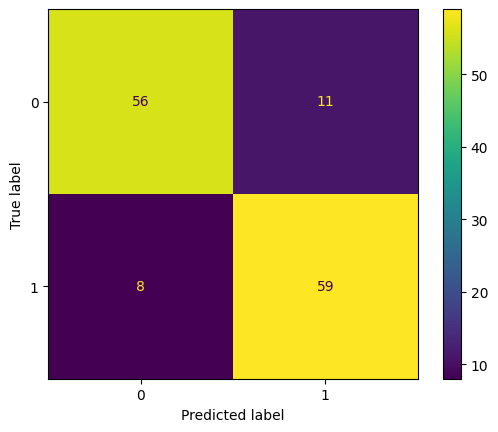

In [1368]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [1369]:
# Accuracy
new_accuracy = metrics.accuracy_score(y_test, y_pred)
new_accuracy
print('Accurcacy multiple regressors (no selection):', new_accuracy)


Accurcacy multiple regressors (no selection): 0.8582089552238806


In [1370]:
# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred)

# Calculate Gini Index
new_gini_index = 2 * auc - 1

print('Accuracy multiple regressors:',accuracy)
print(f"AUC-ROC: {auc}")
print(f"Gini Index: {new_gini_index}")

Accuracy multiple regressors: 0.835820895522388
AUC-ROC: 0.8582089552238806
Gini Index: 0.7164179104477613


In [1371]:
print(f'Gini Index before: {gini_index}')
print(f'Gini Index after: {new_gini_index}')

if new_gini_index > gini_index:
    print('The accuracy has improved')
else:
    print('The accuracy is worse')

Gini Index before: 0.6716417910447761
Gini Index after: 0.7164179104477613
The accuracy has improved


# Outlier analysis

In [1372]:
phone_df = pd.read_csv('data/phone.csv')
phone_df.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


In [1373]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   resolution         1512 non-null   object 
 5   battery            1512 non-null   int64  
 6   battery_type       1512 non-null   object 
 7   ram(GB)            1512 non-null   int64  
 8   announcement_date  1512 non-null   object 
 9   weight(g)          1512 non-null   float64
 10  storage(GB)        1512 non-null   int64  
 11  video_720p         1512 non-null   bool   
 12  video_1080p        1512 non-null   bool   
 13  video_4K           1512 non-null   bool   
 14  video_8K           1512 non-null   bool   
 15  video_30fps        1512 non-null   bool   
 16  video_60fps        1512 

In [1374]:
y = phone_df['price(USD)']
X = phone_df.drop(columns='price(USD)')

In [1375]:
# Numerical columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
print(numeric_columns.to_list())


['inches', 'battery', 'ram(GB)', 'weight(g)', 'storage(GB)']


In [1376]:
X[['feature_0']].hist()

KeyError: "None of [Index(['feature_0'], dtype='object')] are in the [columns]"

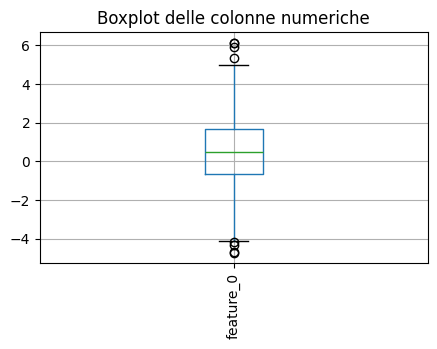

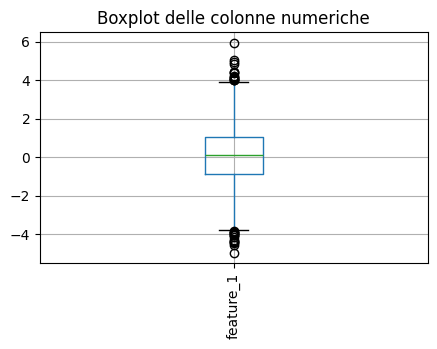

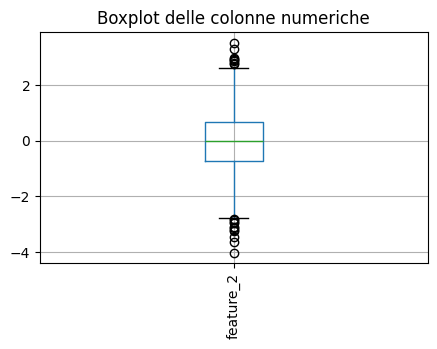

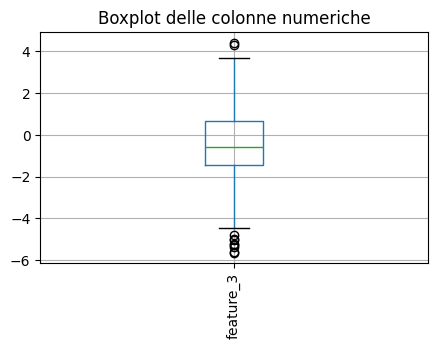

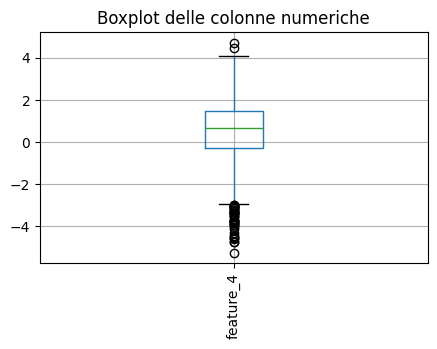

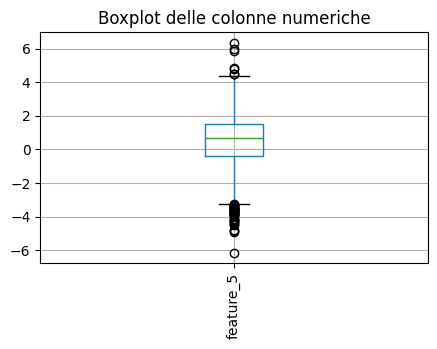

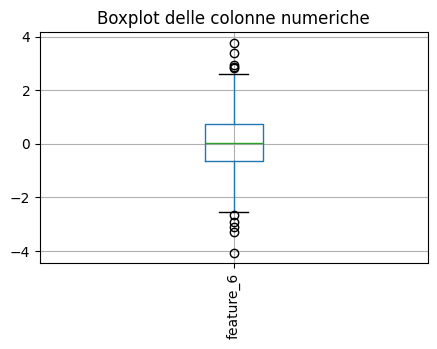

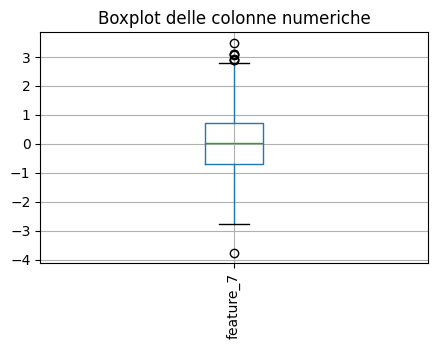

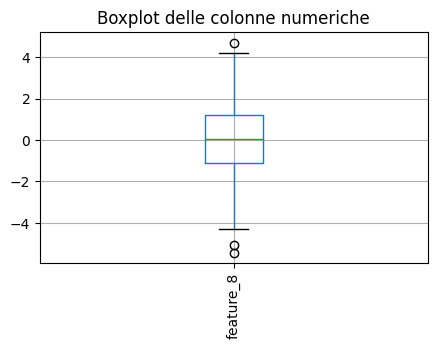

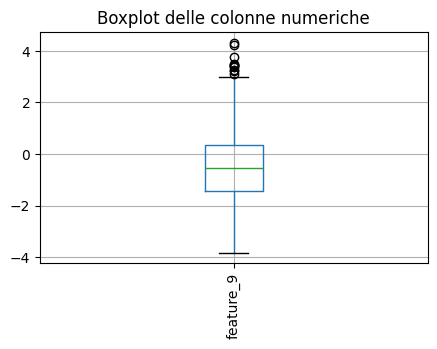

In [ ]:
# Boxplot
for i in numeric_columns:
    plt.figure(figsize=(5, 3))
    X[[i]].boxplot()
    plt.xticks(rotation=90)
    plt.title('Boxplot delle colonne numeriche')
    plt.show()
    

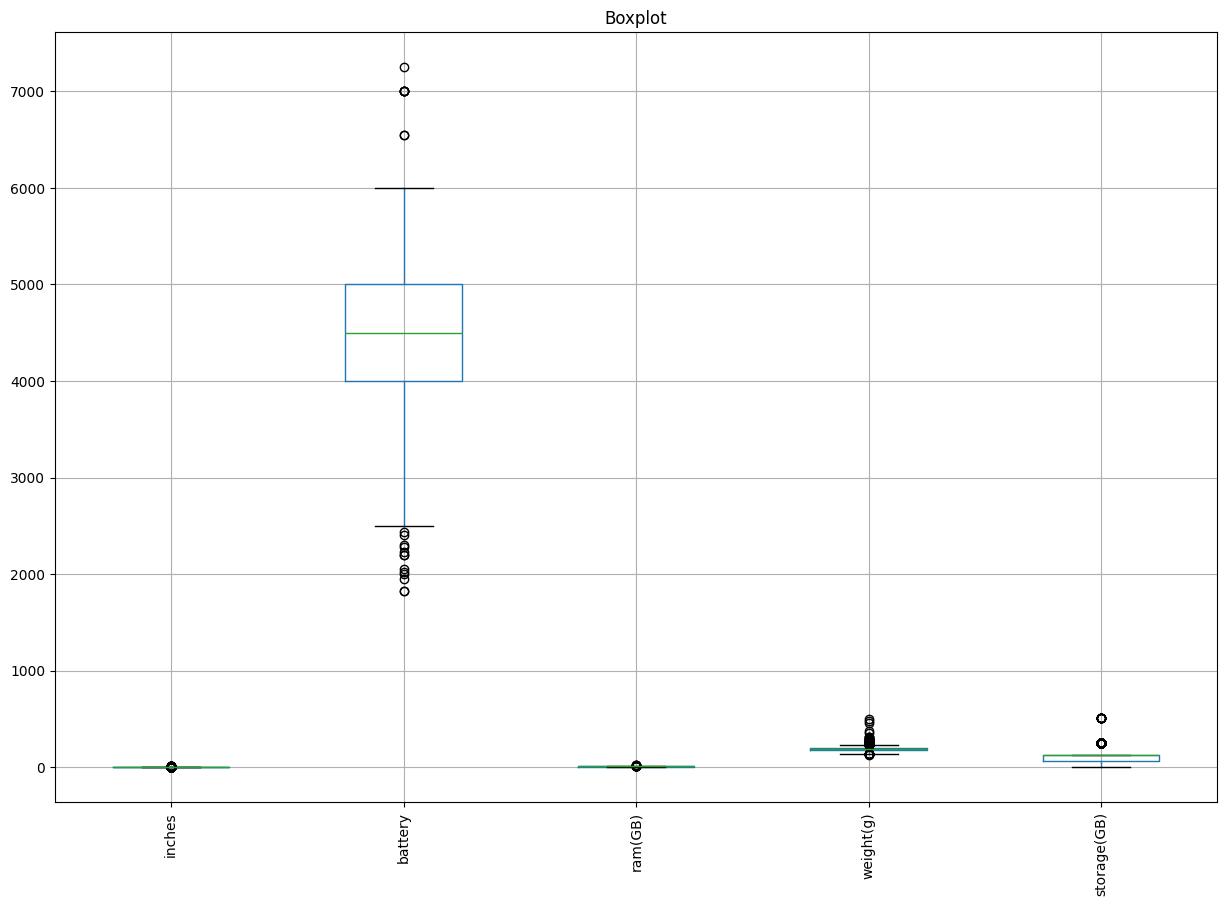

In [ ]:
from packages.data_analysis import standard_box_plot

standard_box_plot(X[numeric_columns])

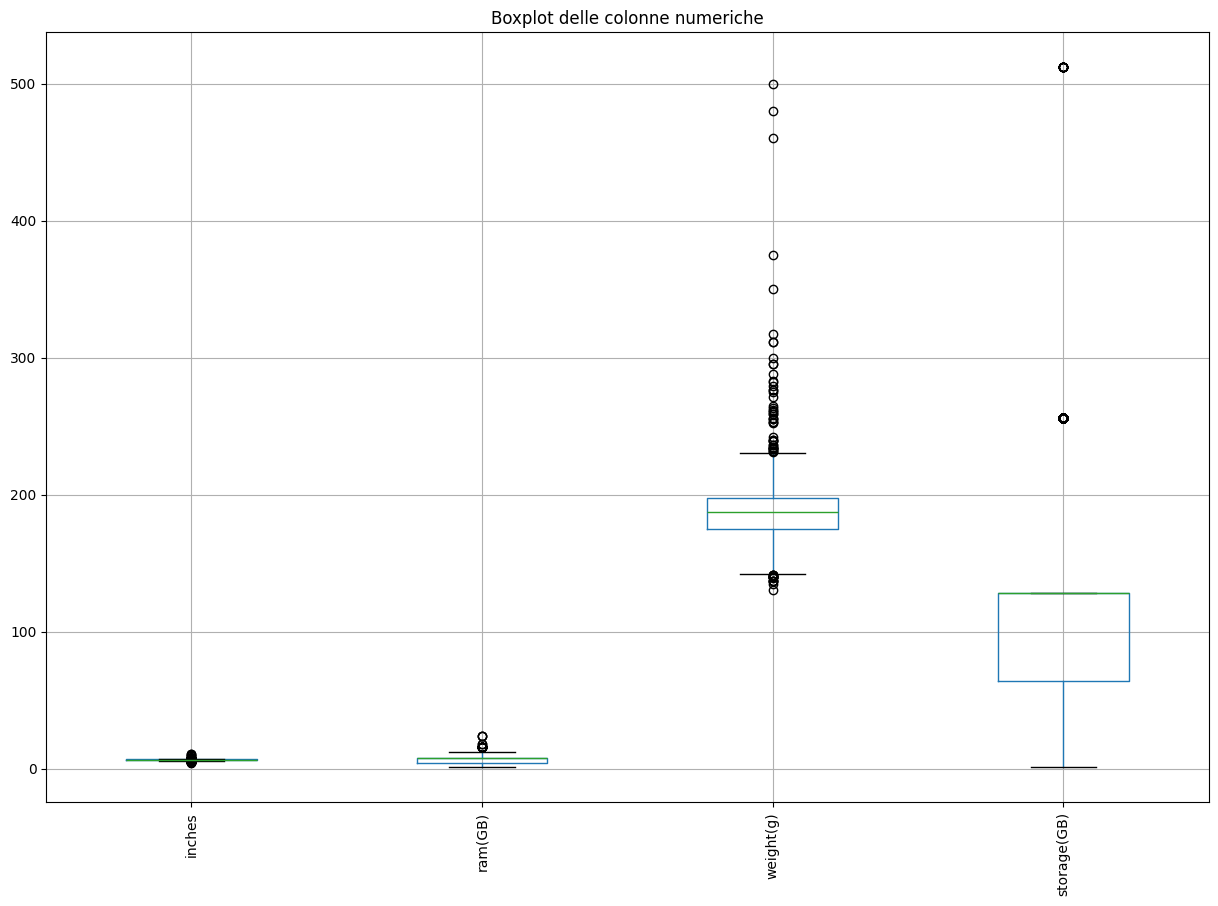

In [ ]:
# Boxplot
plt.figure(figsize=(15, 10))
X[numeric_columns].drop(columns='battery').boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot delle colonne numeriche')
plt.show()

In [ ]:
X.describe()

,inches,battery,ram(GB),weight(g),storage(GB)
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,6.422460,4389.798942,6.683862,187.636243,109.164683
std,0.477043,784.607022,2.701433,26.200115,74.436484
min,3.800000,1821.000000,1.000000,130.000000,1.000000
25%,6.300000,4000.000000,4.000000,175.000000,64.000000
50%,6.500000,4500.000000,8.000000,187.000000,128.000000
75%,6.670000,5000.000000,8.000000,197.250000,128.000000
max,10.400000,7250.000000,24.000000,500.000000,512.000000


In [ ]:
# Interquartile range
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = {column: find_outliers(X, column) for column in numeric_columns}
outliers

{'inches':               phone_name    brand           os  inches resolution  battery  \
 0           Y6II Compact   Huawei  Android 5.1    5.00   720x1280     2200   
 1               K20 plus       LG  Android 7.0    5.30   720x1280     2700   
 2         P8 Lite (2017)   Huawei  Android 7.0    5.20  1080x1920     3000   
 3           Redmi Note 4   Xiaomi  Android 6.0    5.50  1080x1920     4100   
 4                    P10   Huawei  Android 7.0    5.10  1080x1920     3200   
 ...                  ...      ...          ...     ...        ...      ...   
 1436          Pixel Fold   Google   Android 13    7.60  1840x2208     4821   
 1489            Magic V2    Honor   Android 13    7.92  2156x2344     5000   
 1492  Legion Y700 (2023)   Lenovo   Android 13    8.80  1600x2560     6550   
 1497      Galaxy Z Fold5  Samsung   Android 13    7.60  1812x2176     4400   
 1504          Mix Fold 3   Xiaomi   Android 13    8.03  1916x2160     4800   
 
      battery_type  ram(GB) announcement

In [ ]:
outliers['battery'].head(5)

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_720p,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,True,False,False,False,True,False,False,False,False,False
5,Xperia XA1,Sony,Android 7.0,5.0,720x1280,2300,Li-Ion,3,2017-02-01,143.0,...,False,True,False,False,True,False,False,False,False,False
27,Y3 (2017),Huawei,Android 6.0,5.0,480x854,2200,Li-Ion,1,2017-05-01,175.0,...,True,False,False,False,True,False,False,False,False,False
28,Z4,Samsung,Tizen 3.0,4.5,480x800,2050,Li-Ion,1,2017-05-01,143.0,...,True,False,False,False,True,False,False,False,False,False
45,Galaxy Folder2,Samsung,Android 6.0,3.8,480x800,1950,Li-Ion,3,2017-07-01,165.0,...,False,True,False,False,True,False,False,False,False,False


In [ ]:
# Outliers count
outliers_count = {column: len(outliers[column]) for column in numeric_columns}

outliers_stats = {}
for column in numeric_columns:
    outliers_stats[column] = {
        'Number of Outliers': len(outliers[column]),
        'Percentage of Outliers': (len(outliers[column]) / len(df)) * 100,
        'Outlier Values': outliers[column][column].values
    }

outliers_stats_df = pd.DataFrame(outliers_stats).transpose()
outliers_stats_df

,Number of Outliers,Percentage of Outliers,Outlier Values
inches,164,24.624625,"[5.0, 5.3, 5.2, 5.5, 5.1, 5.0, 5.2, 5.5, 5.5, ..."
battery,21,3.153153,"[2200, 2300, 2200, 2050, 1950, 1821, 2000, 700..."
ram(GB),35,5.255255,"[16, 16, 16, 16, 16, 18, 16, 18, 16, 16, 16, 1..."
weight(g),65,9.75976,"[140.0, 140.0, 141.0, 140.0, 137.0, 130.0, 500..."
storage(GB),167,25.075075,"[256, 256, 512, 256, 256, 512, 512, 256, 512, ..."


# Feature Selection


The primary goals of feature selection are to create a more accurate, interpretable, and efficient model by identifying and retaining the most relevant features while discarding irrelevant or redundant ones. This process enhances model performance, reduces computational costs, and provides better insights into the underlying patterns in the data.

### 1. Regression Feature Selection: (Numerical Input, Numerical Output)
Pearson's Correlation Coefficient via the f_regression()

In [1377]:
# Informative features numeber
n_informative = 5

# generate dataset
X, y, coef = make_regression(n_samples=200000, n_features=10, n_informative=n_informative, coef=True, random_state=42)


In [1378]:
# Identify indices of informative features (positive coefficients)
informative_indices = [i for i, c in enumerate(coef) if c > 0]

# Print the results
print("Indices of informative features (positive coefficients):", informative_indices)

Indices of informative features (positive coefficients): [0, 1, 5, 6, 9]


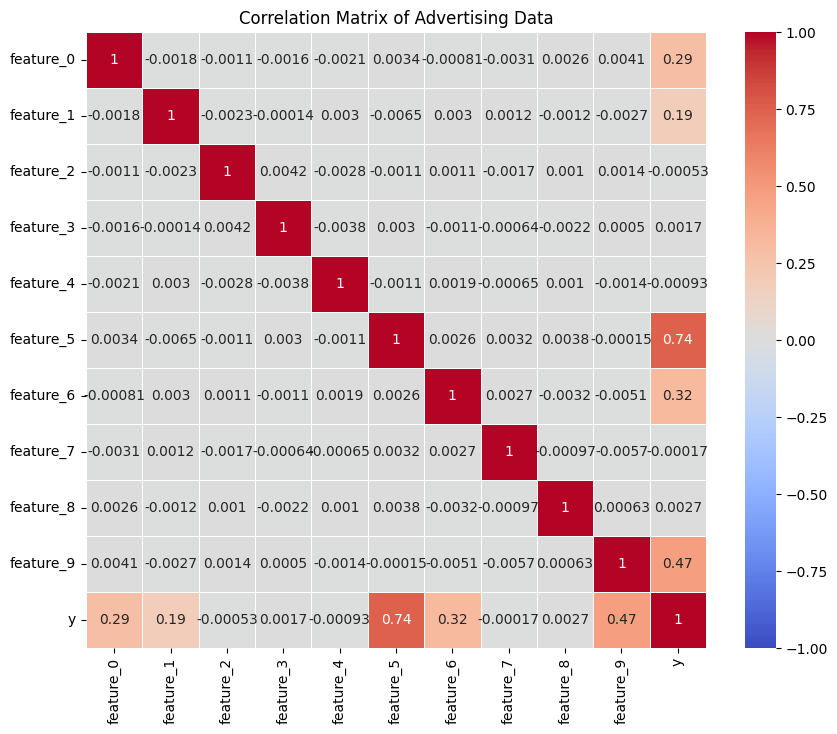

In [1379]:
X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
X_df['y'] = y
correlation_matrix = X_df.corr()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Advertising Data')
plt.show()

This code demonstrates the generation of a synthetic regression dataset using the make_regression function from scikit-learn. It specifically focuses on creating a dataset with a mix of informative features (relevant for the target variable) and irrelevant features.

In [1380]:
# define feature selection
fs = SelectKBest(score_func=f_regression, k=n_informative)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(200000, 5)


In [1381]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]


print("Selected Features with SelectKBest:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(informative_indices).intersection(set(selected_indices))
selected_informative = [str(i) for i in selected_informative]

print("Original Informative Features:", selected_informative)

# Sets comparison
if set(selected_features) == set(selected_informative):
    print("The selected features are the same as the informative features")

Selected Features with SelectKBest: ['0', '1', '5', '6', '9']
Original Informative Features: ['0', '1', '5', '6', '9']
The selected features are the same as the informative features


### 2. Classification Feature Selection: (Numerical Input, Categorical Output)
ANOVA F measure via the f_classif() function

In [1382]:
# Informative features numeber
n_informative = 5

# generate dataset
X, y = make_classification(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)

# define feature selection
fs = SelectKBest(score_func=f_classif, k=n_informative)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(2000, 5)


We observe that class 0, corresponding to non-defaults, contains 9,667 observations, while class 1, representing defaults, has only 333 observations. This significant disparity in class distribution makes the dataset highly imbalanced, a characteristic that could hinder the model's ability to generalize, particularly in accurately predicting the minority class.

In [1383]:
# Corr y vs. every column of X
correlations = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]

# Index for the 5 most correlated features
most_correlated = np.argsort(np.abs(correlations))[::-1][:n_informative].tolist()
print(most_correlated)


[3, 5, 4, 1, 0]


In [1384]:
# Informative features according to SelectKBest
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Selected Features with SelectKBest:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(most_correlated).intersection(set(selected_indices))
selected_informative = [str(i) for i in selected_informative]

print("Original Informative Features:", selected_informative)
# Sets comparison
if set(selected_features) == set(selected_informative):
    print("The selected features are the same as the informative features")

Selected Features with SelectKBest: ['0', '1', '3', '4', '5']
Original Informative Features: ['0', '1', '3', '4', '5']
The selected features are the same as the informative features


### (Incomplete) Classification Feature Selection: (Categorical Input, Categorical Output)

In [1471]:
# Informative features numeber
n_informative = 5

# ANOVA feature selection for numeric input and categorical output
X, y = make_classification(n_samples=20000, n_features=10, n_informative=n_informative, random_state=42)

# Create cols names
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
X_columns = [f'{letters[i]}' for i in range(X.shape[1])] 
X = pd.DataFrame(X, columns=X_columns)
X.head()

,A,B,C,D,E,F,G,H,I,J
0,-0.044647,-2.200269,0.518588,1.088586,0.483994,1.797486,2.979231,-0.340273,0.723112,-1.041167
1,2.247163,4.331179,-0.325120,-0.966243,0.488939,0.838522,0.777931,3.347686,-0.915013,1.946786
2,2.987879,1.688979,-0.133203,1.973367,0.275564,-0.901788,1.255137,0.846208,0.606994,-0.398827
3,1.536536,-0.115136,-1.191740,3.518600,-0.718960,-0.775311,0.590636,-0.696778,-2.246269,2.104057
4,2.852694,-1.156515,0.830967,2.292079,-0.334035,0.729799,-1.370045,-3.514967,0.402869,0.663173


In [1472]:
# Identify indices of informative features (positive coefficients)
informative_indices = [i for i, c in enumerate(coef) if c > 0]

# Print the results
print("Indices of informative features (positive coefficients):", informative_indices)


Indices of informative features (positive coefficients): [0, 1, 5, 6, 9]


## Transform Numerical in Categorical

In [1498]:
n_bins = 10

# Create bins for each column
X_binned = pd.DataFrame(columns=X_columns)
for column in X_columns:
    X_binned[str(column)] = pd.cut(X[column], bins=n_bins, labels=False)

# Convert every column to categorical
for column in X_binned.columns:
    X_binned[column] = X_binned[column].astype('category')

X_binned.head()

,A,B,C,D,E,F,G,H,I,J
0,4,2,5,4,5,6,7,4,5,5
1,6,7,4,3,5,5,5,6,4,7
2,6,5,4,5,5,3,5,4,5,5
3,5,4,3,7,4,3,5,3,3,7
4,6,3,5,6,4,5,3,2,5,6


In [1499]:
informative_letters = [letters[i] for i in informative_indices]
informative_letters

['A', 'B', 'F', 'G', 'J']

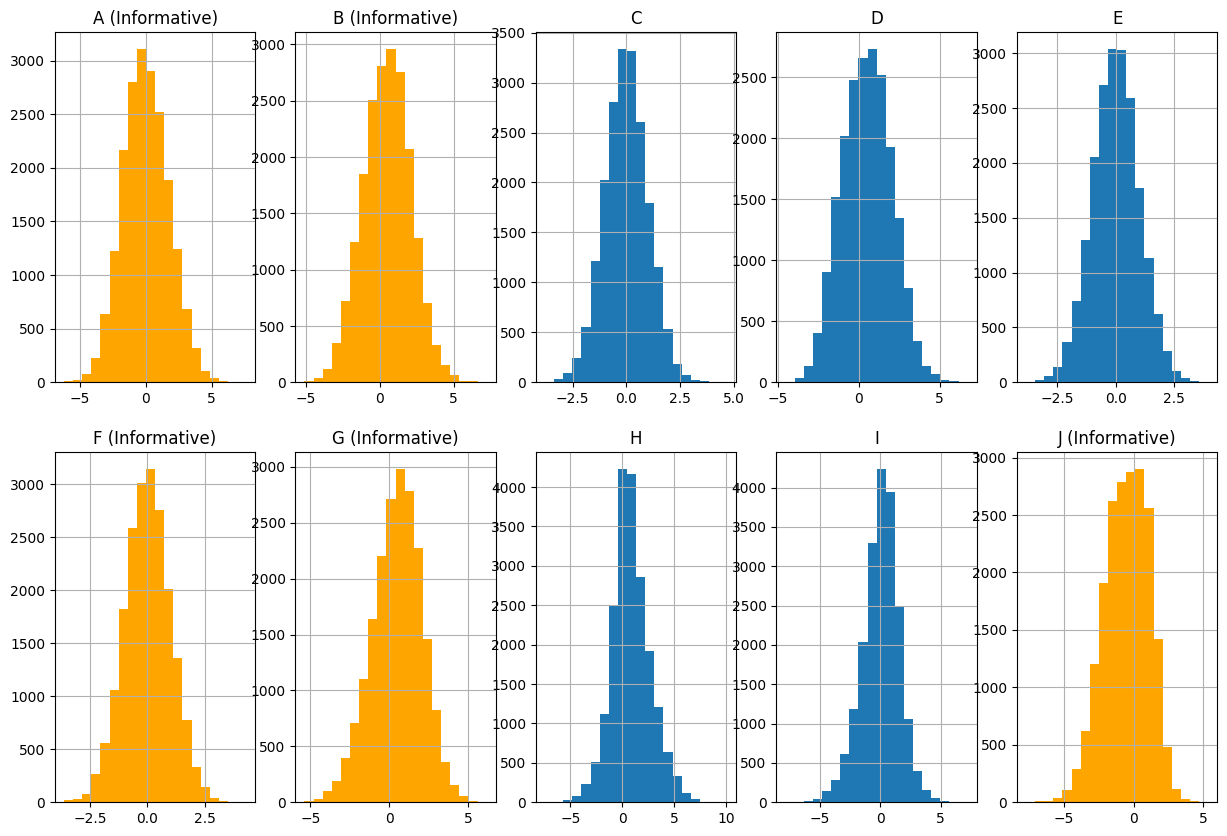

In [1500]:
# Create histograms for x 
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    
    plt.subplot(2, 5, i + 1)
    if i in informative_indices:
        X[column].hist(bins=20, color='orange')
        plt.title(column + ' (Informative)')
    else:
        X[column].hist(bins=20)
        plt.title(column)
    
    
plt.show()


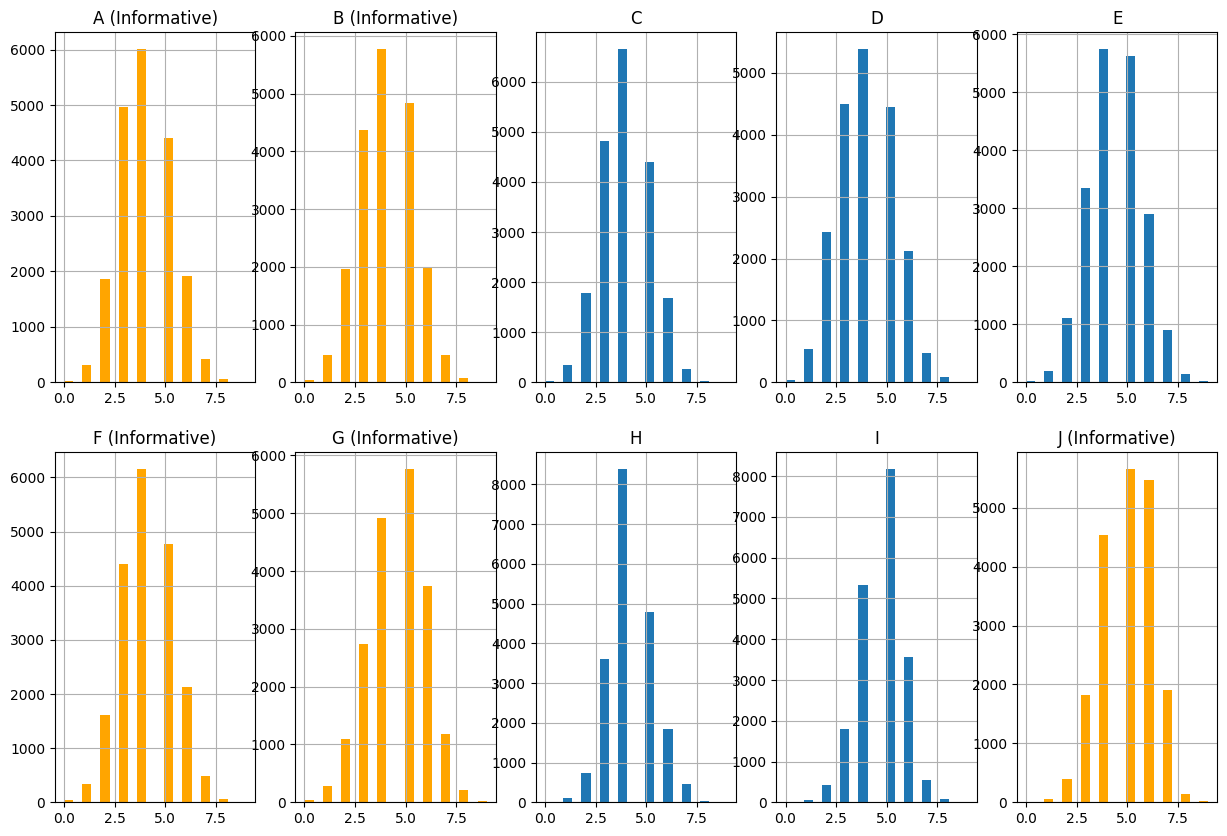

In [1501]:
# Create histograms for x binned
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    plt.subplot(2, 5, i + 1)
    
    if i in informative_indices:
        X_binned[column].hist(bins=20, color='orange')
        plt.title(column + ' (Informative)')
    else:
        X_binned[column].hist(bins=20)
        plt.title(column)
plt.show()

## Feature Selection of qualitative variables

In [1502]:
X_binned.head()

,A,B,C,D,E,F,G,H,I,J
0,4,2,5,4,5,6,7,4,5,5
1,6,7,4,3,5,5,5,6,4,7
2,6,5,4,5,5,3,5,4,5,5
3,5,4,3,7,4,3,5,3,3,7
4,6,3,5,6,4,5,3,2,5,6


In [1503]:
print(informative_indices)

[0, 1, 5, 6, 9]


In [1504]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder().fit(X) # OneHotEncoder(drop='first').fit(X) if you want to drop the first column

X_encoded = encoder.fit_transform(X_binned)
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(X_columns))
X_encoded.head()


,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,...,J_0,J_1,J_2,J_3,J_4,J_5,J_6,J_7,J_8,J_9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1505]:
# Define feature selection
fs = SelectKBest(score_func=chi2, k=n_informative*n_bins)

# Apply feature selection
X_selected = fs.fit_transform(X_encoded, y)


In [1511]:
# Retrieve feature scores and sort by informativeness
scores = fs.scores_  # Scores for all features
np.set_printoptions(suppress=True, precision=6) # Beter print formatting

marked_features = ["> " + str(X_encoded.columns[i]) if X_encoded.columns[i].split('_')[0] in informative_letters else X_encoded.columns[i] for i in range(X_encoded.shape[1])]
sorted_features = sorted(zip(marked_features, scores), key=lambda x: x[1], reverse=True)

# Convert to a DataFrame for better visualization (optional)
sorted_df = pd.DataFrame(sorted_features, columns=["Feature", "Score"])
sorted_df.head(20)


,Feature,Score
0,> J_7,1018.929329
1,> J_6,932.164374
2,> B_2,861.629411
3,> J_4,821.275314
4,D_2,794.104704
5,> G_2,604.033621
6,> B_5,582.769865
7,> G_3,536.753973
8,> J_5,473.656545
9,> B_3,455.356357


In [1509]:
selected_indices = fs.get_support(indices=True)
selected_features = [X_encoded.columns[i] for i in selected_indices]

In [1510]:
print("Selected Features:", selected_features)

for i in selected_indices:
    if i < n_informative*5:
        print(f"Original informative feature: {i//5} - Binned feature: {i}")

Selected Features: ['A_0', 'A_1', 'A_3', 'A_5', 'A_7', 'A_8', 'B_0', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'G_0', 'G_1', 'G_2', 'G_3', 'G_5', 'G_6', 'G_7', 'G_8', 'H_1', 'H_3', 'H_4', 'H_5', 'H_6', 'I_0', 'I_1', 'I_2', 'I_4', 'I_5', 'I_6', 'I_8', 'J_1', 'J_2', 'J_3', 'J_4', 'J_5', 'J_6', 'J_7', 'J_8']
Original informative feature: 0 - Binned feature: 0
Original informative feature: 0 - Binned feature: 1
Original informative feature: 0 - Binned feature: 3
Original informative feature: 1 - Binned feature: 5
Original informative feature: 1 - Binned feature: 7
Original informative feature: 1 - Binned feature: 8
Original informative feature: 2 - Binned feature: 10
Original informative feature: 2 - Binned feature: 11
Original informative feature: 2 - Binned feature: 12
Original informative feature: 2 - Binned feature: 13
Original informative feature: 2 - Binned feature: 14
Original informative feature: 3 - Binned feature: 15
